# embedding analytics

some functions to assess the usefulness of embeddings

In [62]:
import os
import mido
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [63]:
VALID_EXTENSIONS = (".mid", ".midi")

In [64]:
from typing import Callable


def visualize_similarity(
    midi_file_path: str,
    representation_function: Callable[[list], np.ndarray] = None,
    similarity_metric: Callable[[np.ndarray, np.ndarray], float] = None,
) -> None:
    """
    Calculate and visualize the similarity of a specified MIDI segment with all other segments in a file.

    Arguments
    ---------
        midi_file_path (str):
            Full path (including file name) of the midi file to use as the comparator for the similarity function.
        representation_function (Callable[[list], np.ndarray]):
            Function to extract the representation from a segment.
        similarity_metric (Callable[[np.ndarray, np.ndarray], float], optional):
            Function to calculate similarity between two representations.
            Defaults to cosine similarity.

    Returns
    -------
        None: Displays the similarity visualization as a pyplot.
    """
    # default representation: pitch histogram
    if representation_function is None:
        representation_function = lambda x: pretty_midi.PrettyMIDI(
            x
        ).get_pitch_class_histogram(True, True)
    # default similarity metric: cosine similarity
    if similarity_metric is None:
        similarity_metric = lambda x, y: np.dot(x, y) / (
            np.linalg.norm(x) * np.linalg.norm(y)
        )

    # extract representations for all segments
    p_midi = os.path.dirname(midi_file_path)
    midi_file = os.path.basename(midi_file_path)
    midi_segments = [
        os.path.join(p_midi, segment)
        for segment in os.listdir(p_midi)
        if segment.endswith(VALID_EXTENSIONS)
    ]
    print(f"midi path is {p_midi}")
    print(f"midi file is {midi_file}")
    print(f"midi segs ({len(midi_segments)}) is {midi_segments[:3]}")
    try:
        segment_index = midi_segments.index(midi_file_path)
    except ValueError:
        print(f"ERROR: couldn't find key midi file in segment list")
        return
    segment_representations = [
        representation_function(segment) for segment in midi_segments
    ]

    # get the representation of the specified segment
    target_representation = representation_function(midi_file_path)

    # calculate similarity for all segments
    similarities = [
        similarity_metric(target_representation, representation)
        for representation in segment_representations
    ]
    # do a quick validity test
    key_sim = similarity_metric(
        representation_function(midi_file_path), segment_representations[segment_index]
    )
    print(f"self-similarity for key midi file is {key_sim:.05f}")

    # normalize similarities to [0, 1] range
    min_similarity, max_similarity = min(similarities), max(similarities)
    normalized_similarities = [
        (sim - min_similarity) / (max_similarity - min_similarity)
        for sim in similarities
    ]

    # create a piano roll-like visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    # display the piano roll
    track_path = os.path.join(
        p_midi.replace("segmented", "unsegmented"), p_midi.split("/")[-1] + ".mid"
    )
    print(f"track path is {track_path}")
    track_piano_roll = pretty_midi.PrettyMIDI(track_path)

    ax.imshow(
        track_piano_roll,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        extent=[0, len(midi_segments), 0, 128],
    )

    # overlay the similarity scores
    ax.plot(
        range(len(normalized_similarities)),
        np.array(normalized_similarities) * 128,  # scale to match piano roll height
        color="red",
        label="Similarity",
    )

    # highlight the selected segment
    ax.axvline(x=segment_index, color="blue", linestyle="--", label="Selected Segment")

    # add vertical lines at the start and end of each segment
    for idx in range(len(midi_segments) + 1):
        ax.axvline(x=idx, color="black", linestyle="-", linewidth=0.5)

    ax.set_title("MIDI Segment Similarity Visualization")
    ax.set_xlabel("Segment Index")
    ax.set_ylabel("MIDI Pitch / Similarity")
    ax.legend()

    plt.show()

In [65]:
test_file = "/media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03/20240511-088-03_0169-0174.mid"
# visualize_similarity(test_file)

In [71]:
representation_function = lambda x: pretty_midi.PrettyMIDI(x).get_pitch_class_histogram(
    True, True
)
similarity_metric = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# extract representations for all segments
p_midi = os.path.dirname(test_file)
midi_file = os.path.basename(test_file)
midi_segments = [
    os.path.join(p_midi, segment)
    for segment in os.listdir(p_midi)
    if segment.endswith(VALID_EXTENSIONS)
]
print(f"midi path is {p_midi}")
print(f"midi file is {midi_file}")
print(f"midi segments ({len(midi_segments)}) is {midi_segments[:3]}")

try:
    segment_index = midi_segments.index(test_file)
    print(f"segment index is {segment_index}")
except ValueError:
    print(f"ERROR: couldn't find key midi file in segment list")

midi path is /media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03
midi file is 20240511-088-03_0169-0174.mid
midi segments (66) is ['/media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03/20240511-088-03_0174-0179.mid', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03/20240511-088-03_0229-0234.mid', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03/20240511-088-03_0087-0092.mid']
segment index is 43


In [67]:
segment_representations = [
    representation_function(segment) for segment in midi_segments
]

# get the representation of the specified segment
target_representation = representation_function(test_file)

# calculate similarity for all segments
similarities = [
    similarity_metric(target_representation, representation)
    for representation in segment_representations
]
# do a quick validity test
key_sim = similarity_metric(
    representation_function(test_file), segment_representations[segment_index]
)
print(f"self-similarity for key midi file is {key_sim:.05f}")

# normalize similarities to [0, 1] range
min_similarity, max_similarity = min(similarities), max(similarities)
normalized_similarities = [
    (sim - min_similarity) / (max_similarity - min_similarity) for sim in similarities
]

self-similarity for key midi file is 1.00000


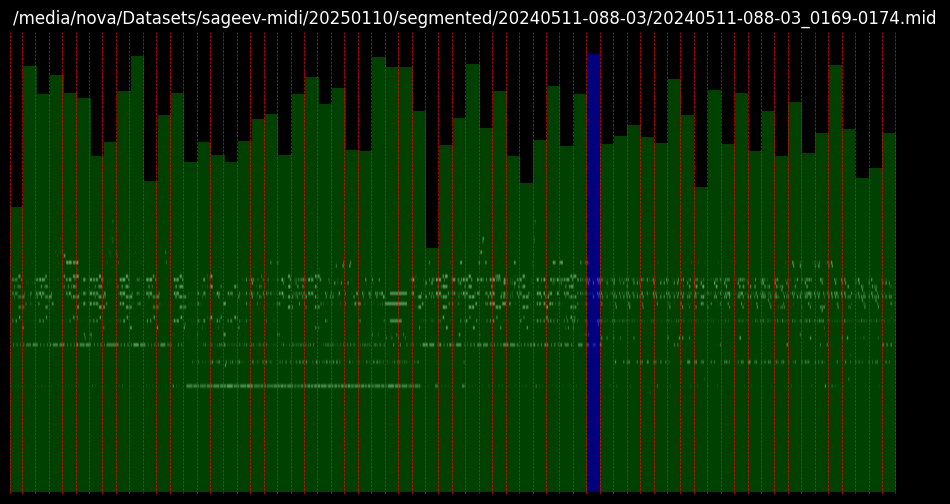

In [74]:
track_path = os.path.join(
    p_midi.replace("segmented", "unsegmented"), p_midi.split("/")[-1] + ".mid"
)

# load file
midi_mido = mido.MidiFile(track_path)
midi_pm = pretty_midi.PrettyMIDI(track_path)

# make piano roll
piano_roll = midi_pm.get_piano_roll() / 128.0

# trim piano roll to remove rows below lowest and above highest notes
row_sums = piano_roll.sum(axis=1)
non_zero_rows = np.where(row_sums > 0)[0]
min_row, max_row = non_zero_rows[0], non_zero_rows[-1]
trimmed_piano_roll = piano_roll[min_row : max_row + 1]

# calculate dimensions for plotting
pr_width = trimmed_piano_roll.shape[1]

# calculate pixel-tick conversion ratio
bpm = int(os.path.basename(track_path).split("-")[1])
num_ticks = mido.second2tick(
    midi_pm.get_end_time(), midi_mido.ticks_per_beat, mido.bpm2tempo(bpm)
)
ticks_per_pixel = pr_width / num_ticks

# extract tick positions for every 8th beat
beat_positions = [0]
num_beats = 0
for track in midi_mido.tracks:
    first_msg = track[0]
    if first_msg.is_meta and first_msg.type == "track_name":
        if first_msg.name != "tick":
            continue

        current_tick = 0
        for msg in track:
            current_tick += msg.time
            num_beats += 1
            if num_beats % 8 == 0:  # only include every 8th beat
                tick_pixel = int(current_tick * ticks_per_pixel)
                if 0 <= tick_pixel < pr_width:
                    beat_positions.append(tick_pixel)

# plot piano roll
plt.figure(figsize=(12, 6))
plt.title(f"{test_file}")
plt.imshow(piano_roll, aspect="auto", origin="lower", cmap="gray")

# plot vertical lines for every 8th beat
for beat in beat_positions:
    plt.axvline(x=beat, color="red", linestyle="--", linewidth=0.5)

# similarity histogram
bin_edges = np.linspace(0, pr_width, num_beats // 8 + 1)
for i, value in enumerate(similarities):
    bin_center = (bin_edges[i] + bin_edges[i + 1]) / 2
    color = "blue" if i == segment_index else "green"
    plt.bar(
        bin_center,
        value * piano_roll.shape[0],
        width=(bin_edges[i + 1] - bin_edges[i]),
        color=color,
        alpha=0.5,
        align="center",
        edgecolor="none",
    )

plt.axis("off")
plt.show()

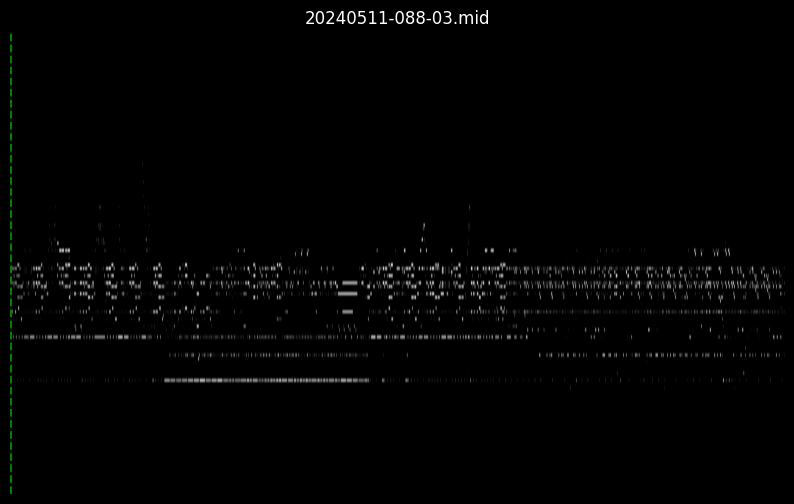

In [7]:
# create a piano roll-like visualization
fig, ax = plt.subplots(figsize=(10, 6))

# display the piano roll
track_path = os.path.join(
    p_midi.replace("segmented", "unsegmented"), p_midi.split("/")[-1] + ".mid"
)
# print(f"track path is {track_path}")
track_piano_roll = pretty_midi.PrettyMIDI(track_path).get_piano_roll()

ax.imshow(
    track_piano_roll,
    aspect="auto",
    origin="lower",
    cmap="gray",
    # extent=[0, len(midi_segments), 0, 128],
)

# overlay the similarity scores
# ax.plot(
#     range(len(normalized_similarities)),
#     np.array(normalized_similarities) * 128,  # scale to match piano roll height
#     color="red",
#     label="Similarity",
# )

# highlight the selected segment
ax.axvline(x=segment_index, color="green", linestyle="--", label="Selected Segment")

# add vertical lines at the start and end of each segment
# for idx in range(len(midi_segments) + 1):
#     ax.axvline(x=idx, color="blue", linestyle="-", linewidth=0.5)

ax.set_title(os.path.basename(track_path))
plt.axis("off")

plt.show()

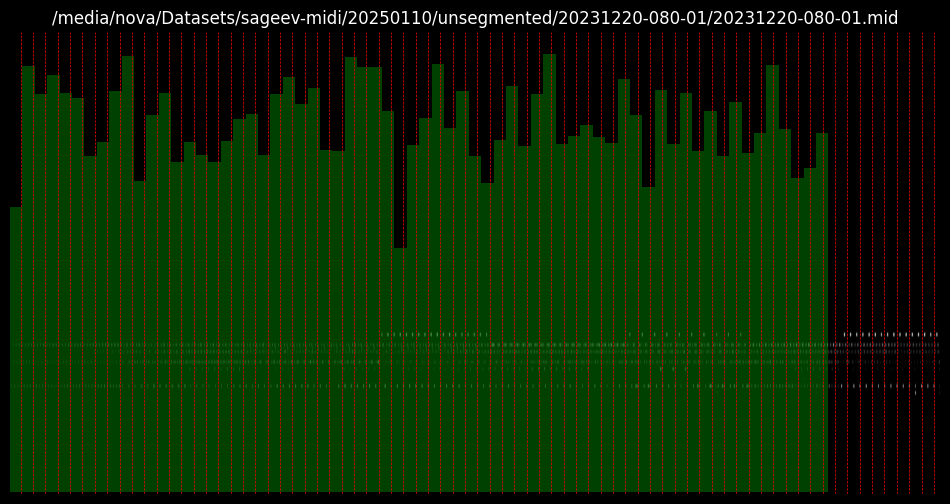

In [61]:
def show_beats(midi_path: str):
    # load file
    midi_mido = mido.MidiFile(midi_path)
    midi_pm = pretty_midi.PrettyMIDI(midi_path)

    # make piano roll
    piano_roll = midi_pm.get_piano_roll() / 128.0

    # trim piano roll to remove rows below lowest and above highest notes
    row_sums = piano_roll.sum(axis=1)
    non_zero_rows = np.where(row_sums > 0)[0]
    min_row, max_row = non_zero_rows[0], non_zero_rows[-1]
    trimmed_piano_roll = piano_roll[min_row : max_row + 1]

    # calculate dimensions for plotting
    pr_width = trimmed_piano_roll.shape[1]

    # calculate pixel-tick conversion ratio
    bpm = int(os.path.basename(midi_path).split("-")[1])
    num_ticks = mido.second2tick(
        midi_pm.get_end_time(), midi_mido.ticks_per_beat, mido.bpm2tempo(bpm)
    )
    ticks_per_pixel = pr_width / num_ticks

    # extract tick positions for every 8th beat
    beat_positions = []
    num_beats = 0
    for track in midi_mido.tracks:
        first_msg = track[0]
        if first_msg.is_meta and first_msg.type == "track_name":
            if first_msg.name != "tick":
                continue

            current_tick = 0
            for msg in track:
                current_tick += msg.time
                num_beats += 1
                if num_beats % 8 == 0:  # only include every 8th beat
                    tick_pixel = int(current_tick * ticks_per_pixel)
                    if 0 <= tick_pixel < pr_width:
                        beat_positions.append(tick_pixel)

    # plot piano roll
    plt.figure(figsize=(12, 6))
    plt.title(f"{midi_path}")
    plt.imshow(piano_roll, aspect="auto", origin="lower", cmap="gray")

    # plot vertical lines for every 8th beat
    for beat in beat_positions:
        plt.axvline(x=beat, color="red", linestyle="--", linewidth=0.5)

    # similarity histogram
    bin_edges = np.linspace(0, pr_width, num_beats // 8 + 1)
    for i, value in enumerate(similarities):
        bin_center = (bin_edges[i] + bin_edges[i + 1]) / 2
        plt.bar(
            bin_center,
            value * piano_roll.shape[0],
            width=(bin_edges[i + 1] - bin_edges[i]),
            color="green",
            alpha=0.5,
            align="center",
            edgecolor="none",
        )

    plt.axis("off")
    plt.show()


show_beats(
    # "/media/nova/Datasets/sageev-midi/20250110/segmented/20231220-080-01/20231220-080-01_0000-0005.mid"
    "/media/nova/Datasets/sageev-midi/20250110/unsegmented/20231220-080-01/20231220-080-01.mid"
)